# ttop for finding hot cores in DSE 6

One of the better ways to find threads that are CPU bound in java is the ttop command from the [jvm-tools project under sjk-core ](https://github.com/aragozin/jvm-tools/blob/master/sjk-core/docs/TTOP.md). DataStax Enterprise already [ships this tooling with nodetool](https://docs.datastax.com/en/dse/6.8/dse-admin/datastax_enterprise/tools/nodetool/toolsSjk.html) so we can use it to diagnose problems with cores that go hot where a single thread dominates. Since cores rarely go hot from a single process in since the release DSE 6.8.7 it maybe less useful in those versions, however in all previous versions of DSE 6.X this is often necessary and can indicate if an upgrade to the latest 6.8 will fix their issue or not.


In [11]:
example_ttop_output = '''
2021-01-11T06:00:00.000+0000 Process summary 
  process cpu=1201.12%
  application cpu=124.14% (user=124.12% sys=45.12%)
  other: cpu=999.12% 
  thread count: 124
  heap allocation rate 931mb/s
[021901] user= 6.79% sys= 4.81% alloc=   12mb/s - RMI TCP Connection(1111)-127.0.0.1
[000052] user=11.88% sys=-0.76% alloc= 1555kb/s - CoreThread-4
[000059] user= 6.79% sys= 2.13% alloc=  4074b/s - ParkedThreadsMonitor
[000037] user= 6.79% sys= 1.38% alloc=   14mb/s - CoreThread-9
[000053] user= 6.79% sys= 0.97% alloc=   13mb/s - CoreThread-5
[000041] user= 6.79% sys= 0.71% alloc=   12mb/s - CoreThread-3


2021-01-11T06:00:01.000+0000 Process summary 
  process cpu=124.12%
  application cpu=124.12% (user=124.71% sys=12.29%)
  other: cpu=19.07% 
  thread count: 144
  heap allocation rate 94mb/s
[000052] user=95.05% sys= 4.12% alloc=     0b/s - CoreThread-2
[000059] user= 4.12% sys= 3.24% alloc=  2485b/s - ParkedThreadsMonitor
[021901] user= 3.12% sys= 1.23% alloc= 1345kb/s - RMI TCP Connection(1111)-127.0.0.1
[000028] user= 2.12% sys=-2.33% alloc= 1234kb/s - CoreThread-9
[000599] user= 0.01% sys= 3.19% alloc= 1234kb/s - MessagingService-Incoming-/192.168.1.2
[000029] user= 2.14% sys=-1.29% alloc= 1244kb/s - CoreThread-3



2021-01-11T06:00:02.000+0000 Process summary 
  process cpu=124.12%
  application cpu=124.12% (user=142.12% sys=34.12%)
  other: cpu=1.98% 
  thread count: 134
  heap allocation rate 114mb/s
[000009] user=95.72% sys= 3.74% alloc=     0b/s - CoreThread-4
[000002] user=38.29% sys=19.56% alloc=  160mb/s - RMI TCP Connection(1111)-127.0.0.1
[000008] user= 7.29% sys= 2.13% alloc=   729b/s - ParkedThreadsMonitor
[000004] user= 4.56% sys= 2.54% alloc= 6128kb/s - JMX server connection timeout 1244
[000001] user= 4.56% sys= 1.76% alloc= 8945kb/s - RMI TCP Connection(1112)-127.0.0.1
[000003] user= 0.91% sys=-0.23% alloc= 1327kb/s - RMI TCP Connection(1113)-127.0.0.1



2021-01-11T06:00:03.000+0000 Process summary 
  process cpu=244.23%
  application cpu=149.07% (user=124.80% sys=-21.14%)
  other: cpu=89.41% 
  thread count: 124
  heap allocation rate 100mb/s
[000052] user=91.57% sys= 5.46% alloc=   953b/s - CoreThread-4
[022318] user=88.89% sys= 5.76% alloc=   44mb/s - RMI TCP Connection(idle)
[000059] user= 6.22% sys= 1.59% alloc=     0b/s - ParkedThreadsMonitor
[021901] user= 4.45% sys= 2.48% alloc= 8713kb/s - RMI TCP Connection(1111)-127.0.0.1
[017686] user= 0.00% sys= 0.26% alloc=  616kb/s - RMI TCP Connection(1113)-127.0.0.1
[000025] user= 0.00% sys= 0.16% alloc=   84kb/s - ScheduledTasks:1


2021-01-11T06:00:04.000+0000 Process summary 
  process cpu=340.24%
  application cpu=342.13% (user=241.30% sys=136.91%)
  other: cpu=-27.97% 
  thread count: 134
  heap allocation rate 1452mb/s
[000053] user=14.52% sys= 4.67% alloc=   28mb/s - CoreThread-5
[000041] user=13.61% sys= 5.13% alloc=   31mb/s - CoreThread-3
[000037] user=13.61% sys= 4.35% alloc=   29mb/s - CoreThread-9
[000042] user=12.70% sys= 5.09% alloc=   27mb/s - CoreThread-4
[000059] user= 7.26% sys= 9.52% alloc=  4935b/s - ParkedThreadsMonitor
[000038] user=10.89% sys= 5.06% alloc=   23mb/s - CoreThread-10


2021-01-11T06:00:05.000+0000 Process summary 
  process cpu=098.49%
  application cpu=086.04% (user=044.58% sys=41.46%)
  other: cpu=2.45%
  thread count: 123
  heap allocation rate 193mb/s
[000059] user= 8.23% sys= 2.78% alloc=  4726b/s - ParkedThreadsMonitor
[000036] user=10.98% sys= 0.42% alloc=   21mb/s - CoreThread-8
[000038] user=10.06% sys= 0.23% alloc=   19mb/s - CoreThread-10
[000051] user=10.06% sys= 1.32% alloc=   14mb/s - CoreThread-3
[000056] user= 7.32% sys= 2.28% alloc=   11mb/s - CoreThread-8
[000031] user= 6.40% sys= 3.13% alloc=   37mb/s - CoreThread-6
'''

In the output we see in the second, third and fourth frame near 100% cores which at least indicates that the CPU is nearly fully busy that entire second and is not able to respond much to other requests. 

* 2nd frame: `[000052] user=95.05% sys= 4.12% alloc=     0b/s - CoreThread-2`
* 3rd frame: `[000009] user=95.72% sys= 3.74% alloc=     0b/s - CoreThread-4`
* 4th frame: ```[000052] user=91.57% sys= 5.46% alloc=   953b/s - CoreThread-4
[022318] user=88.89% sys= 5.76% alloc=   44mb/s - RMI TCP Connection(idle)```

At the same time on these clusters we have relatively light CPU usage compared to total available capacity. In this case, the servers had around 16 real CPUs and 32 threads so in theory there should be plenty of CPU available to process request:

* 2nd frame ``` process cpu=124.12%
  application cpu=124.12% (user=124.71% sys=12.29%)
  other: cpu=19.07% ```
* 3rd frame ```process cpu=124.12%
  application cpu=124.12% (user=142.12% sys=34.12%)
  other: cpu=1.98% ```
* 4th frame ``` process cpu=244.23%
  application cpu=149.07% (user=124.80% sys=-21.14%)
  other: cpu=89.41% ```
  
In effect, most of the of the work is residing on one or two cores at the same time. In the case of these clusters they were dropping mutations frequently despite the total CPU usage and disk IO remaining very low. The following code can be used to graph their issue.

The follow cell will show us a time series of how often this is happening by frame:
  

In [12]:
from matplotlib import pyplot as plt 
import pandas as pd
import re
import dateutil

current_date = None
threads_over_90 = {}
cpu_regex = re.compile(r"\[.*\] user=\s*?(?P<user>\-?[0-9]*.[0-9][0-9])% sys=\s*?(?P<sys>\-?[0-9]*.[0-9][0-9])%.* - (?P<thread>.*)")
date_regex = re.compile(r"^(?P<date>.{10}T.{17}) Process summary")

for line in example_ttop_output.split("\n"):
    date_match = date_regex.search(line)
    thread_match = cpu_regex.search(line)
    if date_match:
        if current_date is not None and current_date not in threads_over_90:
            threads_over_90[current_date] = 0
        current_date = dateutil.parser.isoparse(date_match.group("date"))
    elif thread_match:
        user_cpu = thread_match.group("user")
        sys_cpu = thread_match.group("sys")
        # find all cpu cores with CPU usage over 90% 
        total_cpu = float(user_cpu) + float(sys_cpu)
        if total_cpu > 89.99:
            if current_date in threads_over_90:
                # since we already have entries in this time window we just increment by one
                threads_over_90[current_date] += 1
            else:
                # if this time window has no entries at this time go ahead and create one
                threads_over_90[current_date] = 1
hot_threads_pd = pd.DataFrame(list(threads_over_90.items()), columns=['time','hot'])
hot_threads_pd

,time,hot
0,2021-01-11 06:00:00+00:00,0
1,2021-01-11 06:00:01+00:00,1
2,2021-01-11 06:00:02+00:00,1
3,2021-01-11 06:00:03+00:00,2
4,2021-01-11 06:00:04+00:00,0


Now let us put that in a time series so we can observe how many cores are being hit by high cpu

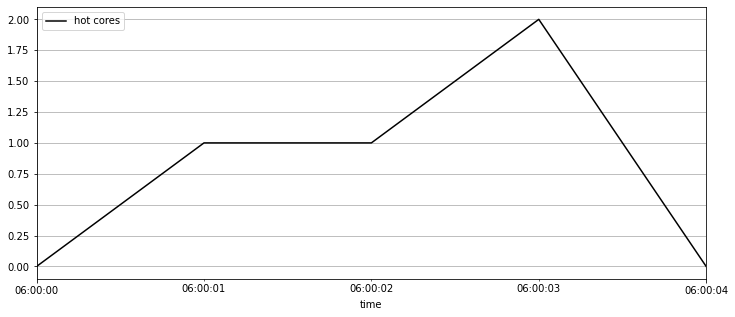

In [13]:

plt.figure(figsize=(12,5))
plt.xlabel('hot cores by time')

ax2 = hot_threads_pd.set_index("time").hot.plot(kind='line', color='black', label="hot cores", grid=True)

h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h2, l2, loc=2)
plt.show()

Now we can search for drops and see at what times they are occuring. In the following log see several messages dropped, these are all network drops:

In [14]:
example_system_log = '''INFO  [ScheduledTasks:1] 2021-01-11 05:59:01,984  DroppedMessages.java:156 - MUTATION messages were dropped in the last 5 s: 1 internal and 0 cross node. Mean internal dropped latency: 1231 ms and Mean cross-node dropped latency: 0 ms
INFO  [ScheduledTasks:1] 2021-01-11 06:00:06,102  DroppedMessages.java:156 - MUTATION messages were dropped in the last 5 s: 0 internal and 12 cross node. Mean internal dropped latency: 0 ms and Mean cross-node dropped latency: 3232 ms
INFO  [ScheduledTasks:1] 2021-01-11 06:00:07,124  DroppedMessages.java:156 - READ_REPAIR messages were dropped in the last 5 s: 0 internal and 3 cross node. Mean internal dropped latency: 0 ms and Mean cross-node dropped latency: 1823 ms
INFO  [ScheduledTasks:1] 2021-01-11 06:01:01,984  DroppedMessages.java:156 - MUTATION messages were dropped in the last 5 s: 10 internal and 1 cross node. Mean internal dropped latency: 1231 ms and Mean cross-node dropped latency: 3823 ms
'''

Now let us search for drops in the logs with some Python. The following code uses a regex to match on the log messages and pull out the count of messages dropped and the time they happened. It will total up the total number of drops for each time and group them down to the milisecond.

In [15]:
import datetime
import pandas as pd


drop_re = re.compile(r"INFO  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - (?P<messageType>\S*) messages were dropped in the last 5 s: (?P<localCount>\d*) internal and (?P<remoteCount>\d*) cross node. Mean internal dropped latency: (?P<localLatency>\d*) ms and Mean cross-node dropped latency: (?P<remoteLatency>\d*) ms")

drops = {}
for line in example_system_log.split("\n"):
    drop_match = drop_re.search(line)
    if drop_match:
        raw_date = drop_match.group('date')
        date = datetime.datetime.strptime(raw_date, "%Y-%m-%d %H:%M:%S,%f")
        local_drops_raw = drop_match.group('localCount')
        local_drops = int(local_drops_raw)
        remote_drops_raw = drop_match.group('remoteCount')
        remote_drops = int(remote_drops_raw)
        total_drops = remote_drops + local_drops
        if date in drops:
            drops[date] += total_drops
        else:
            drops[date] = total_drops
drops_pd = pd.DataFrame(list(drops.items()), columns=['time','drops'])
drops_pd

,time,drops
0,2021-01-11 05:59:01.984,1
1,2021-01-11 06:00:06.102,12
2,2021-01-11 06:00:07.124,3
3,2021-01-11 06:01:01.984,11


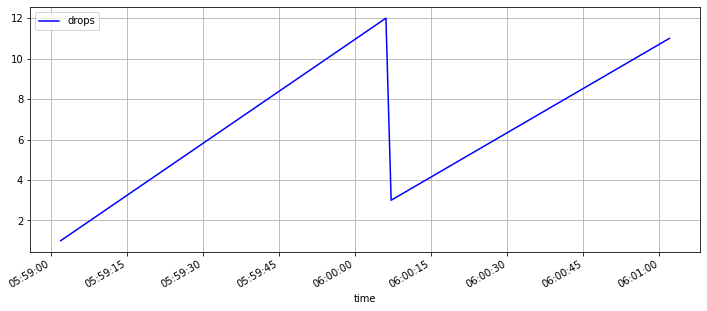

In [16]:
plt.figure(figsize=(12,5))
plt.xlabel('drops laid over time')

ax1 = drops_pd.set_index("time").drops.plot(color='blue', label="drops", grid=True)

h1, l1 = ax1.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()

If we want to overlay the logs with we have a bit of a problem as the ttop windows may not exactly line up with the logs. Let us take a closer look at one of these logs.

```INFO  [ScheduledTasks:1] 2021-01-11 06:00:07,124  DroppedMessages.java:156 - READ_REPAIR messages were dropped in the last 5 s: 0 internal and 3 cross node. Mean internal dropped latency: 0 ms and Mean cross-node dropped latency: 1823 ms```

First you will note this is only tracking the previous 5 seconds of the log, and only when the drops happened and the only latency you get is an average of 1823ms with 3 messages is a pretty good indication of how long the messages were in queue, but there can sometimes be thousands of dropped messages in this window, so it becomes very difficult to say when is the exact second a given drop occurred.

So we will just estimate, everything in the 10 seconds before and after the drop will be considered as connected to a given high CPU event using the following code



In [17]:
import numpy as np

drops_from_hot_core = {}
total_drops_from_hot_core = 0
total_drops = 0

all_windows_with_high_cpu = [x for x in threads_over_90.keys() if threads_over_90[x] > 0]

for time, drop_count in drops.items():
    total_drops += drop_count
    # search each high cpu event
    for high_cpu_time in all_windows_with_high_cpu:
        # a quirk of numpy I need to remove the timezone, these are all in UTC so this is ok
        diff = np.datetime64(high_cpu_time.replace(tzinfo=None)) - np.datetime64(time)
        total_seconds_diff = abs(diff.item().total_seconds())
        if  total_seconds_diff < 10.0 :
            drops_from_hot_core[time] = drop_count
            total_drops_from_hot_core += drop_count
            # once we have connected one event we do not need to connect others
            break

hot_core_pd = pd.DataFrame(list(drops_from_hot_core.items()), columns=['time','drops'])
hot_core_pd

,time,drops
0,2021-01-11 06:00:06.102,12
1,2021-01-11 06:00:07.124,3


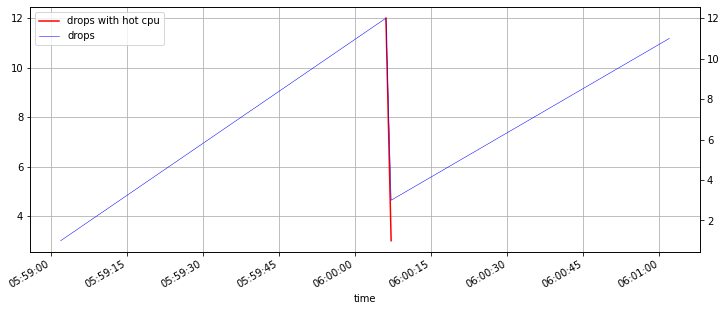

In [18]:

from matplotlib import pyplot as plt 
plt.figure(figsize=(12,5))
plt.xlabel('drops laid over time')

ax1 = hot_core_pd.set_index("time").drops.plot( color='red',label="drops with hot cpu", grid=True)
ax2 = drops_pd.set_index("time").drops.plot(linewidth=0.5, color='blue',secondary_y=True, label="drops", grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

You can now easily see which drops were related to hot cores and which ones where not. If you then divide the drops that were hot from the total drops you get the percentage of drops that were due to the single CPU core being busy.

In [ ]:
"%.2f percent of drops are from hot cores" % ((float(total_drops_from_hot_core)/float(total_drops)) * 100.0)